# Lab12 - Approximate Nearest Neighbors Search

Credits:

- the notebook created by Sebastian Stawicki

The topic of this lab is approximate nearest neighbor (ANN) search. We will utilize this technique to select samples for labeling in an active learning setup.

**A large part of the instructions below is inspired by the tutorial at https://www.pinecone.io/learn/series/faiss/locality-sensitive-hashing.**

## 0. Import libraries

In [3]:
import numpy as np
import pandas as pd

## 1. Data preparation

We are going to use a dataset of tweets collected over one year of the COVID-19 pandemic, which has been prepared for sentiment analysis.

In [4]:
from sklearn.datasets import fetch_openml

TEXT_COLUMN = "text"
TARGET_COLUMN = "sentiment"

bunch = fetch_openml(
    "(Non-)depressive_tweet_data",
    return_X_y=False,
    version=2,
    read_csv_kwargs={"skiprows": [0]},

)
df = bunch.data.set_index("Index")

### Get familiar with the dataset

Investigate the dataset:
- what is the distribution of the sentiment score?
- how many tweets are there?
- what is the distribution of the tweet length?
- investigate short tweets
- investigate long tweets
- etc.

In [5]:
# write your code here
df.head()

,text,sentiment
Index,,
1,'rising cases of covid does not alarm me risin...,1
2,'please vote for chicagoindiaresolution markin...,0
3,'wishing all of you eidaladha hazrat ibrahim a...,1
4,'daily coronavirus cases in india top for firs...,1
5,'sitting here india style watching the raindro...,0


<Axes: >

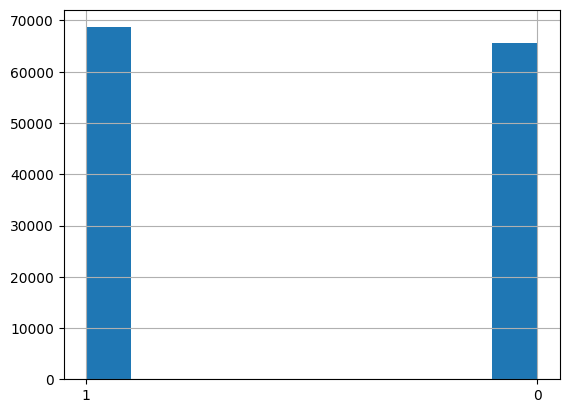

In [7]:
df['sentiment'].hist()

In [8]:
df.count()

text         134329
sentiment    134347
dtype: int64

<Axes: >

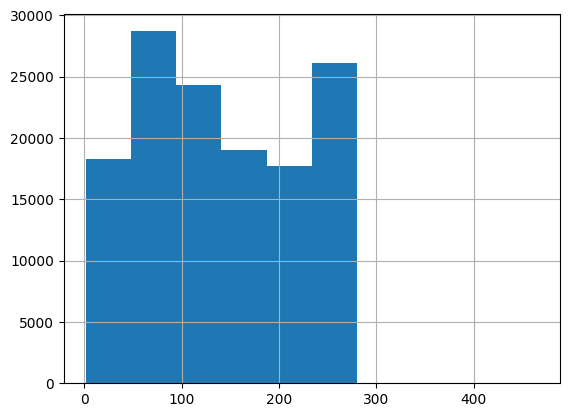

In [9]:
df['text'].str.len().hist()

In [8]:
np.random.choice(df[df['text'].str.len() < 20]['text'], 10)

array(["'youre just doge'", "'still loving you'", "'frank ocean bangs'",
       "'twitter is funny'", "'money bag brad'", 'india', 'india',
       "'right time'", 'india', "'good india'"], dtype=object)

### Clean the dataset

Basing on your investigation, you might want drop short tweets, e.g., introduce a threshold for the minimum number of characters or words in a tweet.

What is the target distribution after that?

<Axes: >

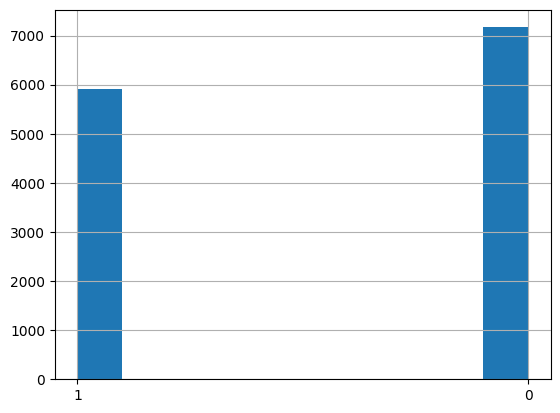

In [10]:
# write your code here

df_selected = df[df['text'].str.len() > 20]
df_selected = df_selected.iloc[:int(0.1*len(df_selected))]
df_selected['sentiment'].hist()



## 2. LSH for text

Locality-sensitive hashing (LSH) is a technique used to speed up the search for nearest neighbors. It works by hashing input items so that similar items map to the same "buckets" with high probability.

LSH is not a single algorithm, but rather a family of approaches that depend on the type of data and the distance metric used. Here, we will implement an example LSH algorithm for text data.

Your implementation might not be the most efficient, but it should help you understand the basic principles of LSH. After gaining some experience through your own implementation, you will use a library that provides a more comprehensive and effective LSH implementation.

At this step you will implement an algorithm consisted of the following steps:

- `K`-shingling/`K`-grams [https://en.wikipedia.org/wiki/W-shingling] - split each text into k-shingles (or k-grams). Use a moving window of size `K` to create a set of k-grams for each tweet. For example, the string "hello world" with `K=2` would produce the shingles: ["he", "el", "ll", "lo", "o ", " w", "wo", "or", "rl", "ld"]. Let `K` be a hyperparameter. (*) You may consider using word `K`-grams instead of character `K`-grams
- create a vocabulary of shingles for all tweets - you should be able to map each unique shingle to a zero-based integer id
- use the vocabulary to encode each tweet as a sparse binary vector - the `i`-th element of the vector should be `1` if the shingle of the `i`-th id is present in the tweet, and `0` otherwise
- MinHashing [https://en.wikipedia.org/wiki/MinHash] - create a MinHash signature of size `L` (a vector of size `L`) for each tweet. The signature is prepared in a way that preserves the Jaccard similarity. Each signature's position corresponds to a permutation of the shingles - the value is the minimal index (considering the permutation) of the shingle that is present in the tweet. E.g., having a binary representation `repr = [0, 0, 1, 1, 0, 1]` and a permutation `permutation = [1, 0, 3, 5, 4, 2]` the minhash value (one of `L` from the signature) is equal to `2`. Let `L` be a hyperparameter.
- LSH with the banding approach - split MinHash signature vectors into `M` bands of size `B` (assume that `L = B * M`). Each band is a vector of size `B`. The idea is to hash each band separately and use the hash value to identify candidate pairs of similar tweets. In our case, let the hash function for bands be the identity function. It is sufficient for a single band to match for a given pair to be considered a candidate pair. For example, let `signature1 = [3, 9, 10, 23, 0, 11]`, `signature2 = [123, 0, 10, 23, 31, 1]`, `B = 2`, and `M = 3`. Then, `signature1_bands = [[3, 9], [10, 23], [0, 11]]`, `signature2_bands = [[123, 0], [10, 23], [31, 1]]`.
Since there is a match in the second band `[10, 23]`, we should consider the two tweets as candidates for being similar. Let `M` and `B` be hyperparameters. For a given dataset, prepare the index structure for LSH. For each band, there should be a hash table that maps the band's hash value to a list of tweet ids. This way, for a new tweet, you can compute its shingles, MinHash signature, and bands, then check the hash table for each band to find candidate tweets and finally take the union of all candidates.

In [11]:
# write your code here
from functools import reduce
from tqdm import tqdm
def get_word_k_gram(text, k):
    words = text.split()
    return [' '.join(words[i:i+k]) for i in range(len(words) - k + 1)]

grams = df_selected['text'].apply(lambda x: get_word_k_gram(x, 2))
unique_grams = grams.explode().unique()
mapper = {k: v for v, k in enumerate(unique_grams)}

result = np.zeros((len(unique_grams), len(grams)), dtype='bool')

for(i, row) in tqdm(enumerate(grams), total = len(grams)):
    for shingle in row:
        result[mapper[shingle], i] = True
L = 8
min_hashed = np.zeros((L, len(grams)), dtype='uint64')
for i in tqdm(range(L)):
    min_hashed[i, :] = np.argmax(result[np.random.permutation(range(len(unique_grams))), :], axis=0)


100%|██████████| 8/8 [00:58<00:00,  7.36s/it]


In [12]:
M = 4
index = {}
for i, row in tqdm(enumerate(min_hashed.T), total=min_hashed.shape[1]):
    step = len(row) // M
    for band in range(M):
        curr_band = tuple(row[step * band: step * (band + 1)])
        if(curr_band not in index.keys()):
            index[curr_band] = []
        index[curr_band].append(i)

100%|██████████| 13085/13085 [00:00<00:00, 50549.28it/s]


In [35]:
index

{(np.uint64(508), np.uint64(3280)): [0],
 (np.uint64(1583), np.uint64(926)): [0],
 (np.uint64(4914), np.uint64(10844)): [0],
 (np.uint64(8532), np.uint64(1575)): [0],
 (np.uint64(8437), np.uint64(1690)): [1],
 (np.uint64(9805), np.uint64(96)): [1],
 (np.uint64(4575), np.uint64(11304)): [1],
 (np.uint64(20293), np.uint64(372)): [1],
 (np.uint64(9223), np.uint64(1858)): [2],
 (np.uint64(19112), np.uint64(3573)): [2],
 (np.uint64(5316), np.uint64(11326)): [2],
 (np.uint64(11095), np.uint64(1011)): [2],
 (np.uint64(7638), np.uint64(2724)): [3],
 (np.uint64(23367), np.uint64(3774)): [3],
 (np.uint64(22387), np.uint64(4109)): [3, 1860],
 (np.uint64(10547), np.uint64(2424)): [3],
 (np.uint64(2402), np.uint64(5209)): [4],
 (np.uint64(11226), np.uint64(623)): [4],
 (np.uint64(3000), np.uint64(10708)): [4],
 (np.uint64(15492), np.uint64(3089)): [4],
 (np.uint64(6988), np.uint64(679)): [5],
 (np.uint64(4386), np.uint64(20062)): [5],
 (np.uint64(9138), np.uint64(6541)): [5],
 (np.uint64(25860), np

### Test your implementation

Prepare an experiment to test your implementation.

As a reference (let us refer to it as ground truth), compute the `N` (e.g., `N=10`) nearest neighbors for each tweet’s `K`-shingle representation using a brute-force search with Jaccard similarity. You can use scikit-learn for this purpose.

Then, use your LSH index to find the candidates for each tweet and choose the top `N` with the highest Jaccard similarity to the query tweet. Compare the obtained results with the ground truth using recall

$$\frac{|GroundTruth \cap Predicted|}{|GroundTruth|}$$


In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm


N = 2
n_tweets = result.shape[1]
X = result.T
nbrs = NearestNeighbors(n_neighbors=N+1,
                        metric='jaccard',
                        algorithm='brute',
                        n_jobs=-1).fit(X)
distances, indices = nbrs.kneighbors(X)
ground_truth = {
    i: set(indices[i, 1: N+1])
    for i in range(n_tweets)
}
prediction = {}
for i, row in tqdm(enumerate(min_hashed.T), total=min_hashed.shape[1]):
    step = len(row) // M
    prediction[i] = []
    for band in range(M):
        curr_band = tuple(row[step * band: step * (band + 1)])
        prediction[i].append(index[curr_band])


NameError: name 'result' is not defined

## 3. ANN with a library

Use the `faiss` library to repeat the experiment from the previous step. Compare the results and computation time with your implementation.

Try different features and approaches.

In [ ]:
# write your code here





## 4*. Application of ANN in active learning

Apply the ANN approach in the active learning setup, e.g., the Lab-05 distance-based diversity approach. You can use the `faiss` library to implement batch sampling that incorporates both informativeness and diversity of the samples.


In [ ]:
# write your code here



